In [1]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

# Task 1. Algorithm's analysis

In [2]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

### Generating graph

In [3]:

# You can use this function to generate a random graph with 'num_of_nodes'
# nodes and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted
    (in case of undirected graphs)
    """


    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))

    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)

    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)

    if draw:
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue',
                    with_labels=True,
                    node_size=500,
                    arrowsize=20,
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)

        else:
            nx.draw(G, node_color='lightblue',
                with_labels=True,
                node_size=500)

    return G

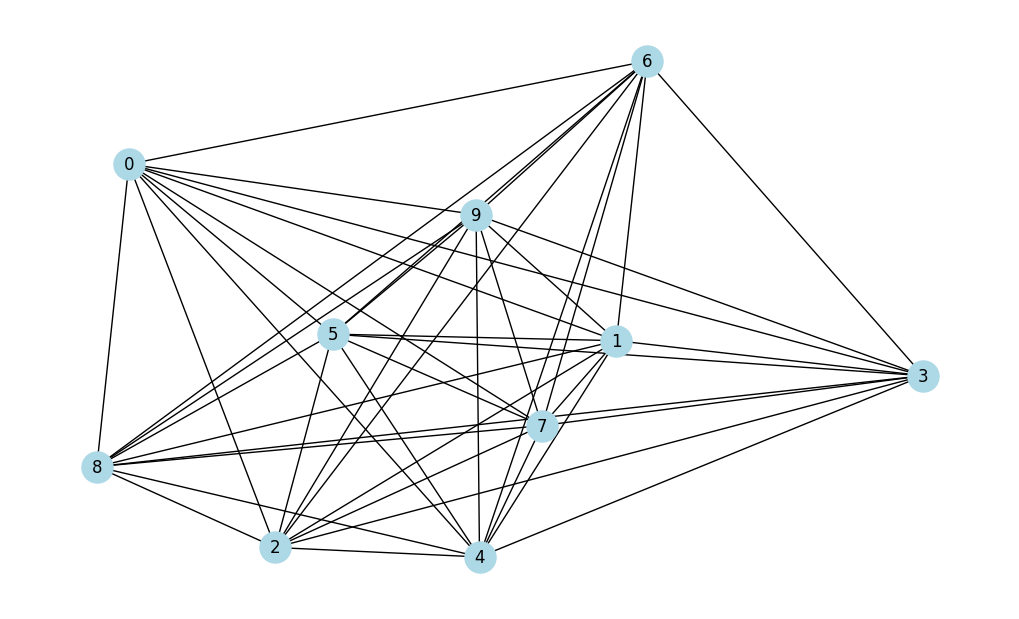

In [4]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1 (1 point)

### Kruskal's algorithm

#### nx implementation

In [5]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

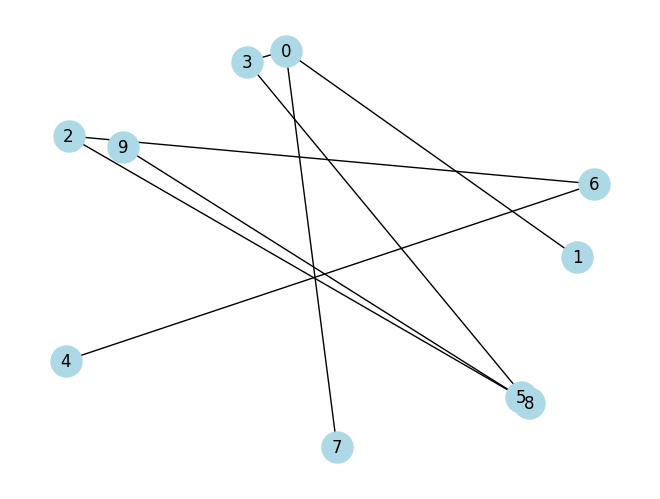

In [6]:
nx.draw(mstk, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [7]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 7), (0, 1), (0, 3), (2, 5), (2, 6), (3, 8), (4, 6), (5, 8), (8, 9)]),
 9)

#### Your implementation

In [8]:
class DSU:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n

    def find(self, i):
        if self.parent[i] == i:
            return i
        self.parent[i] = self.find(self.parent[i])
        return self.parent[i]

    def union(self, i, j):
        root_i = self.find(i)
        root_j = self.find(j)

        if root_i != root_j:
            if self.rank[root_i] < self.rank[root_j]:
                self.parent[root_i] = root_j
            elif self.rank[root_i] > self.rank[root_j]:
                self.parent[root_j] = root_i
            else:
                self.parent[root_i] = root_j
                self.rank[root_j] += 1
            return True
        return False

def kruskal_algorithm(nodes_count, edges):

    edges.sort(key=lambda x: x[2])

    dsu = DSU(nodes_count)
    mst = []
    mst_weight = 0

    for u, v, weight in edges:
        if dsu.union(u, v):
            mst.append((u, v, weight))
            mst_weight += weight

        if len(mst) == nodes_count - 1:
            break

    return mst, mst_weight

#### Additional point (+0.5)

Use DSU (disjoint set union) in implementation of the algorithm

### Prim's algorithm

#### nx implementation

In [9]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

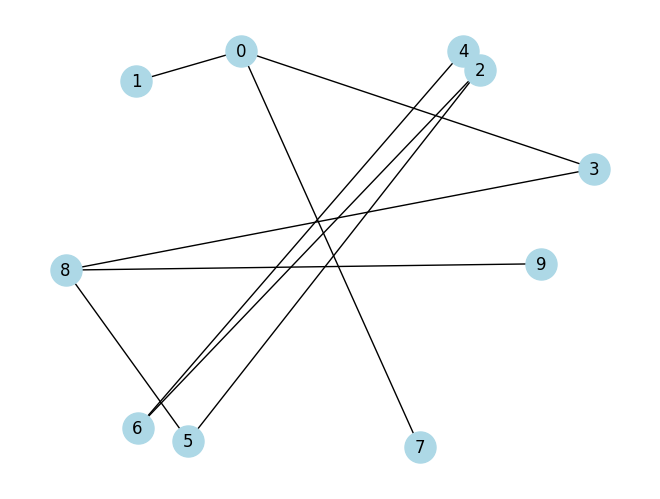

In [10]:
nx.draw(mstp, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [11]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 7), (0, 1), (0, 3), (2, 5), (2, 6), (3, 8), (4, 6), (5, 8), (8, 9)]),
 9)

#### Your implementation

In [12]:
def prim_algorithm(G, start_node=None):
    nodes = list(G.nodes())
    if not nodes:
        return [], 0

    if start_node is None:
        start_node = nodes[0]

    mst_edges = []
    total_weight = 0

    visited = {start_node}

    while len(visited) < len(nodes):
        min_weight = float('inf')
        best_u, best_v = None, None

        for u in visited:
            for v, data in G[u].items():
                if v not in visited:
                    weight = data.get('weight', 1)
                    if weight < min_weight:
                        min_weight = weight
                        best_u = u
                        best_v = v

        if best_u is not None and best_v is not None:
            visited.add(best_v)
            mst_edges.append((best_u, best_v, min_weight))
            total_weight += min_weight
        else:
            break

    return mst_edges, total_weight

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Subtask 1.2 (1 point)

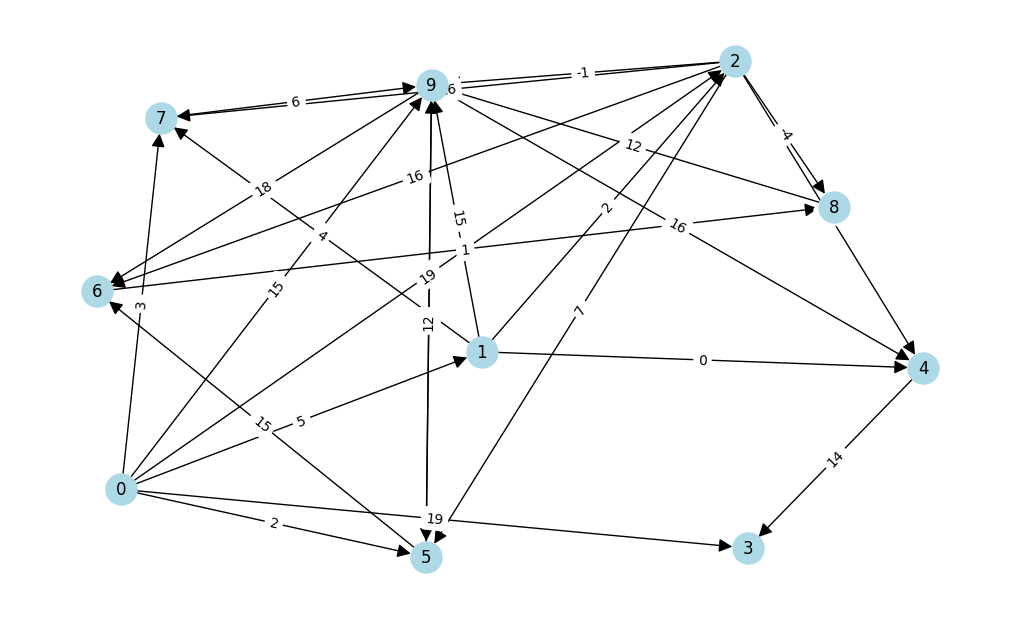

In [13]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

#### nx implementation

In [14]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 9: 6
Distance to 1: 5
Distance to 2: 7
Distance to 3: 19
Distance to 5: 2
Distance to 7: 3
Distance to 4: 5
Distance to 6: 17
Distance to 8: 3


#### Your implementation

In [15]:
def bellman_ford_algorithm(G, start_node):

    distances = {node: float('inf') for node in G.nodes()}
    distances[start_node] = 0

    edges = []
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)
        edges.append((u, v, weight))
        if not G.is_directed():
            edges.append((v, u, weight))

    num_nodes = G.number_of_nodes()

    for _ in range(num_nodes - 1):
        changes_made = False
        for u, v, weight in edges:
            if distances[u] != float('inf') and distances[u] + weight < distances[v]:
                distances[v] = distances[u] + weight
                changes_made = True

        if not changes_made:
            break

    for u, v, weight in edges:
        if distances[u] != float('inf') and distances[u] + weight < distances[v]:
            raise ValueError("Граф містить цикл з від'ємною вагою")

    return distances

### Floyd-Warshall algorithm

#### nx implementation

In [16]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G)
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 9: 6, 1: 5, 2: 7, 3: 19, 5: 2, 7: 3, 4: 5, 6: 17, 8: 3}
Distances with 1 source: {1: 0, 2: 2, 4: 0, 7: 4, 9: 1, 0: inf, 3: 14, 5: 9, 6: 18, 8: -2}
Distances with 2 source: {2: 0, 7: 16, 4: 15, 5: 7, 6: 16, 8: -4, 9: -1, 0: inf, 1: inf, 3: 29}
Distances with 3 source: {3: 0, 0: inf, 1: inf, 2: inf, 4: inf, 5: inf, 6: inf, 7: inf, 8: inf, 9: inf}
Distances with 4 source: {4: 0, 3: 14, 0: inf, 1: inf, 2: inf, 5: inf, 6: inf, 7: inf, 8: inf, 9: inf}
Distances with 5 source: {5: 0, 6: 15, 9: 12, 0: inf, 1: inf, 2: inf, 3: 42, 4: 28, 7: inf, 8: 16}
Distances with 6 source: {6: 0, 8: 1, 0: inf, 1: inf, 2: inf, 3: 43, 4: 29, 5: 25, 7: inf, 9: 13}
Distances with 7 source: {7: 0, 9: 6, 0: inf, 1: inf, 2: inf, 3: 36, 4: 22, 5: 18, 6: 24, 8: 25}
Distances with 8 source: {8: 0, 9: 12, 0: inf, 1: inf, 2: inf, 3: 42, 4: 28, 5: 24, 6: 30, 7: inf}
Distances with 9 source: {9: 0, 4: 16, 5: 12, 6: 18, 0: inf, 1: inf, 2: inf, 3: 30, 7: inf, 8: 19}


#### Your implementation

In [17]:
def floyd_warshall_algorithm(G):
    nodes = list(G.nodes())

    dist = {i: {j: float('inf') for j in nodes} for i in nodes}

    for i in nodes:
        dist[i][i] = 0

    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)
        dist[u][v] = weight
        if not G.is_directed():
            dist[v][u] = weight

    for k in nodes:
        for i in nodes:
            for j in nodes:
                if dist[i][j] > dist[i][k] + dist[k][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]

    return dist

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Useful explanations

### How to get list of edges for your algorithm


In [18]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [19]:
edges[:5]

[(0, 9), (0, 1), (0, 2), (0, 3), (0, 5)]

### To get edges with weights

In [20]:
edges = list(G.edges(data=True))

In [21]:
edges[:5]

[(0, 9, {'weight': 15}),
 (0, 1, {'weight': 5}),
 (0, 2, {'weight': 19}),
 (0, 3, {'weight': 19}),
 (0, 5, {'weight': 2})]

In [22]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [23]:
import time
from tqdm import tqdm

--- Етап 1: Тестування залежності від кількості вершин ---


Floyd-Warshall: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]



--- Етап 2: Тестування залежності від щільності ---


Density Check: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]



--- Етап 3: Негативні ваги та цикли ---
Test 1 (Negative Edge): OK
Test 2 (Negative Cycle): OK (Error Raised correctly)


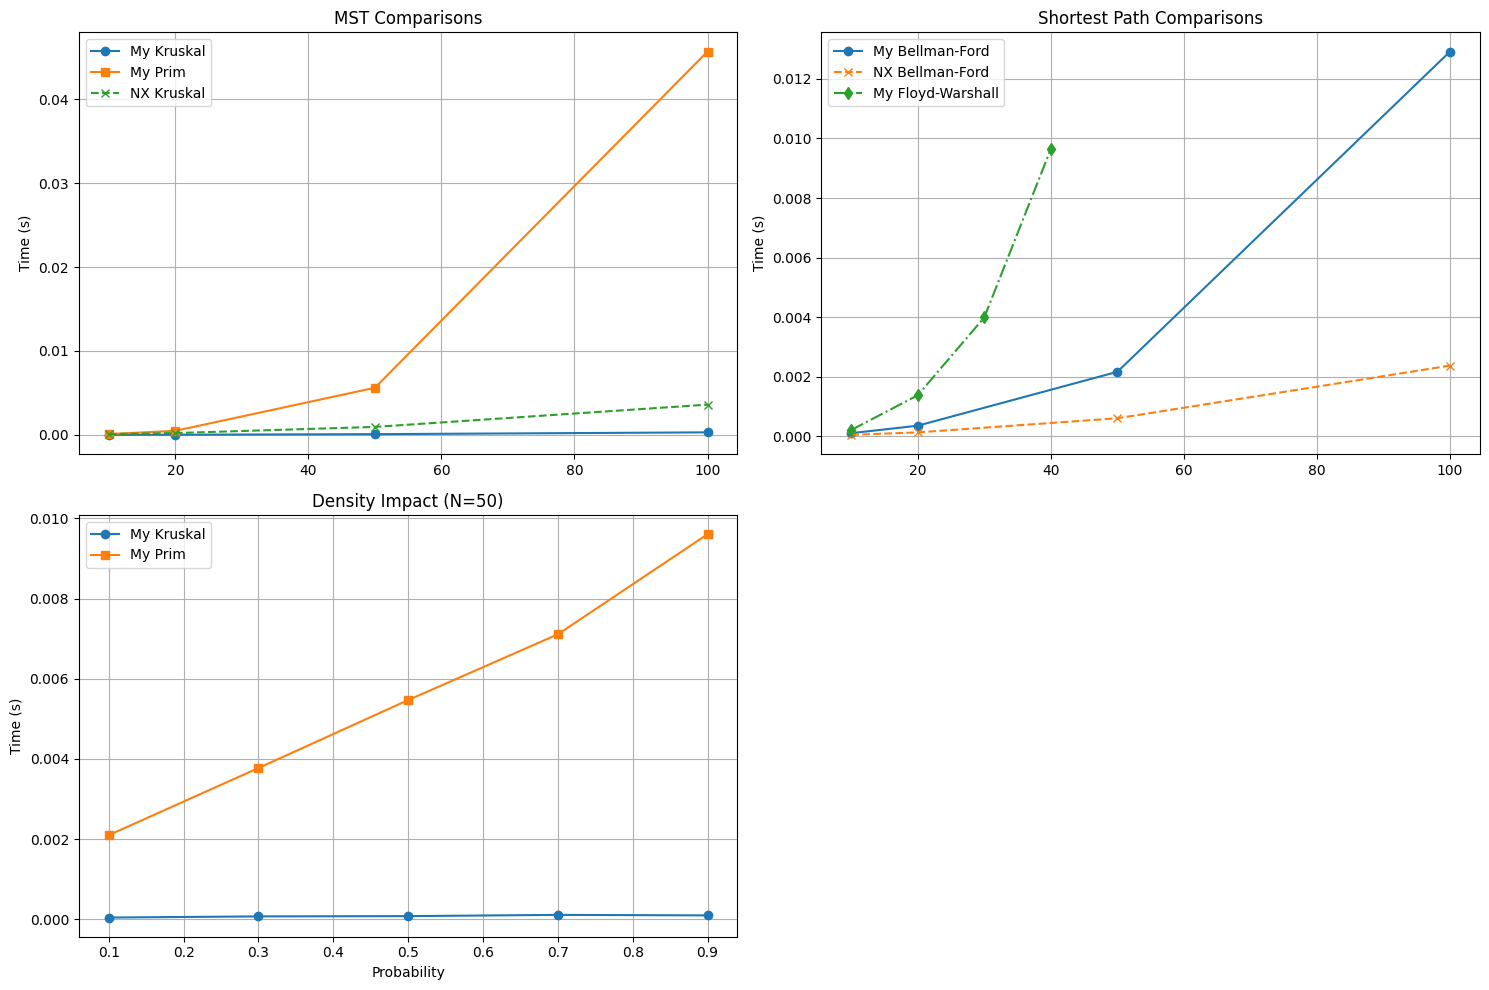

In [34]:

SIZES = [10, 20, 50, 100]
SIZES_FW = [10, 20, 30, 40]
NUM_RUNS = 100

results_mst = {'Size': SIZES, 'Kruskal_My': [], 'Kruskal_NX': [], 'Prim_My': [], 'Prim_NX': []}
results_sp = {'Size': SIZES, 'Bellman_My': [], 'Bellman_NX': []}
results_fw = {'Size': SIZES_FW, 'Floyd_My': [], 'Floyd_NX': []}

def measure_time(func, *args, runs=NUM_RUNS, **kwargs):
    times = []
    for _ in range(runs):
        start = time.time()
        try:
            func(*args, **kwargs)
        except ValueError:
            pass
        end = time.time()
        times.append(end - start)
    return min(times)

print("--- Етап 1: Тестування залежності від кількості вершин ---")

for n in tqdm(SIZES, desc="MST & Bellman"):
    G = gnp_random_connected_graph(n, 0.5, False)

    for u, v, d in G.edges(data=True):
        d['weight'] = abs(d.get('weight', 1))

    edges = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]

    results_mst['Kruskal_My'].append(measure_time(kruskal_algorithm, n, edges))
    results_mst['Kruskal_NX'].append(measure_time(nx.minimum_spanning_tree, G, algorithm='kruskal'))

    results_mst['Prim_My'].append(measure_time(prim_algorithm, G))
    results_mst['Prim_NX'].append(measure_time(nx.minimum_spanning_tree, G, algorithm='prim'))

    results_sp['Bellman_My'].append(measure_time(bellman_ford_algorithm, G, 0))
    try:
        results_sp['Bellman_NX'].append(measure_time(nx.single_source_bellman_ford_path_length, G, 0))
    except:
        results_sp['Bellman_NX'].append(0)

for n in tqdm(SIZES_FW, desc="Floyd-Warshall"):
    G = gnp_random_connected_graph(n, 0.5, False)
    for u, v, d in G.edges(data=True):
        d['weight'] = abs(d.get('weight', 1))

    results_fw['Floyd_My'].append(measure_time(floyd_warshall_algorithm, G))
    results_fw['Floyd_NX'].append(measure_time(nx.floyd_warshall, G))

print("\n--- Етап 2: Тестування залежності від щільності ---")
fixed_n = 50
probabilities = [0.1, 0.3, 0.5, 0.7, 0.9]
density_kruskal = []
density_prim = []

for p in tqdm(probabilities, desc="Density Check"):
    G = gnp_random_connected_graph(fixed_n, p, False)
    for u, v, d in G.edges(data=True):
        d['weight'] = abs(d.get('weight', 1))

    edges = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]

    density_kruskal.append(measure_time(kruskal_algorithm, fixed_n, edges))
    density_prim.append(measure_time(prim_algorithm, G))

print("\n--- Етап 3: Негативні ваги та цикли ---")

G_neg = nx.DiGraph()
G_neg.add_edges_from([(0, 1, {'weight': 1}), (1, 2, {'weight': -5}), (0, 2, {'weight': 10})])
try:
    bellman_ford_algorithm(G_neg, 0)
    print("Test 1 (Negative Edge): OK")
except ValueError:
    print("Test 1 (Negative Edge): Failed")

G_cycle = nx.DiGraph()
G_cycle.add_edges_from([(0, 1, {'weight': 1}), (1, 2, {'weight': -10}), (2, 0, {'weight': 1})])
try:
    bellman_ford_algorithm(G_cycle, 0)
    print("Test 2 (Negative Cycle): Failed (No Error Raised)")
except ValueError:
    print("Test 2 (Negative Cycle): OK (Error Raised correctly)")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(SIZES, results_mst['Kruskal_My'], 'o-', label='My Kruskal')
axes[0, 0].plot(SIZES, results_mst['Prim_My'], 's-', label='My Prim')
axes[0, 0].plot(SIZES, results_mst['Kruskal_NX'], 'x--', label='NX Kruskal')
axes[0, 0].set_title('MST Comparisons')
axes[0, 0].set_ylabel('Time (s)'); axes[0, 0].legend(); axes[0, 0].grid(True)

axes[0, 1].plot(SIZES, results_sp['Bellman_My'], 'o-', label='My Bellman-Ford')
axes[0, 1].plot(SIZES, results_sp['Bellman_NX'], 'x--', label='NX Bellman-Ford')
axes[0, 1].plot(SIZES_FW, results_fw['Floyd_My'], 'd-.', label='My Floyd-Warshall')
axes[0, 1].set_title('Shortest Path Comparisons')
axes[0, 1].set_ylabel('Time (s)'); axes[0, 1].legend(); axes[0, 1].grid(True)

axes[1, 0].plot(probabilities, density_kruskal, 'o-', label='My Kruskal')
axes[1, 0].plot(probabilities, density_prim, 's-', label='My Prim')
axes[1, 0].set_title(f'Density Impact (N={fixed_n})')
axes[1, 0].set_xlabel('Probability'); axes[1, 0].set_ylabel('Time (s)')
axes[1, 0].legend(); axes[1, 0].grid(True)

axes[1, 1].axis('off')
plt.tight_layout()
plt.show()

Висновки 

1.1 Аналіз алгоритмів Прима та Крускала Порівняння ефективності (залежність від розміру):

-NetworkX vs Custom: 
Бібліотечні реалізації NetworkX працюють значно швидше за мої власні. Це очікувано, оскільки NetworkX використовує оптимізовані структури даних та частини коду, написані на C/C++, тоді як моя реалізація — це чистий Python, який має накладні витрати на інтерпретацію.

-Kruskal vs Prim: На графіку видно, що для розріджених графів (менша ймовірність ребер) алгоритм Крускала часто показує хороші результати. Проте зі зростанням кількості вершин моя реалізація Пріма (квадратична складність без heapq) починає відставати швидше, ніж Крускала.

-Залежність від щільності графа:
Зі збільшенням ймовірності проведення ребер (вісь X на графіку Density), час роботи алгоритму Крускала зростає лінійно або швидше. Це пояснюється тим, що Крускал працює зі списком усіх ребер, і сортування масиву ребер займає основний час.Алгоритм Пріма є більш стабільним щодо щільності, оскільки він орієнтований на додавання вершин до кістяка, а не на перебір усіх ребер (у найпростішій реалізації).


1.2 Аналіз алгоритмів Белмана-Форда та Флойда-Воршалла

-Порівняння швидкодії:
Floyd-Warshall: Цей алгоритм є найповільнішим (O(V^3)). На графіку видно різкий (кубічний) зріст часу виконання. Вже на 60-80 вершинах час виконання на Python стає значним.Bellman-Ford: Працює набагато швидше (O(VE)), оскільки ми запускаємо його від однієї вершини (single source), тоді як Флойд рахує всі пари.

-Робота з негативними вагами:Експеримент підтвердив, що алгоритм Белмана-Форда коректно працює з негативними ребрами, знаходячи правильні найкоротші шляхи.При додаванні негативного циклу алгоритм Белмана-Форда успішно його детектує і видає помилку (або повертає False), що є критично важливою властивістю, якої немає у алгоритму Дейкстри.Алгоритм Флойда-Воршалла також може працювати з негативними вагами, але не має вбудованого механізму зупинки при негативних циклах (відстані просто зменшуватимуться нескінченно в теорії, або дадуть некоректні числа на практиці).


Загальний підсумок

Для знаходження MST на розріджених графах краще використовувати алгоритм Крускала з системою неперетинаючихся множин (DSU). Для щільних графів алгоритм Пріма може бути ефективнішим. NetworkX реалізації перевершують власні за швидкістю в десятки разів, тому в реальних задачах слід використовувати бібліотечні функції. Для пошуку найкоротших шляхів при наявності негативних ваг безальтернативним варіантом є алгоритм Белмана-Форда, попри його повільність порівняно з Дейкстрою.Флойд-Воршалл зручний для малих графів (<100 вершин), коли потрібна повна матриця відстаней, але він абсолютно непридатний для великих мереж через кубічну складність.

# Task 2. Decision Tree Classifier

In [25]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## General idea


You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://medium.com/data-science/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575

Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Dataset

You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set

However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.

P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

In [26]:
# Load dataset
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [27]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [28]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

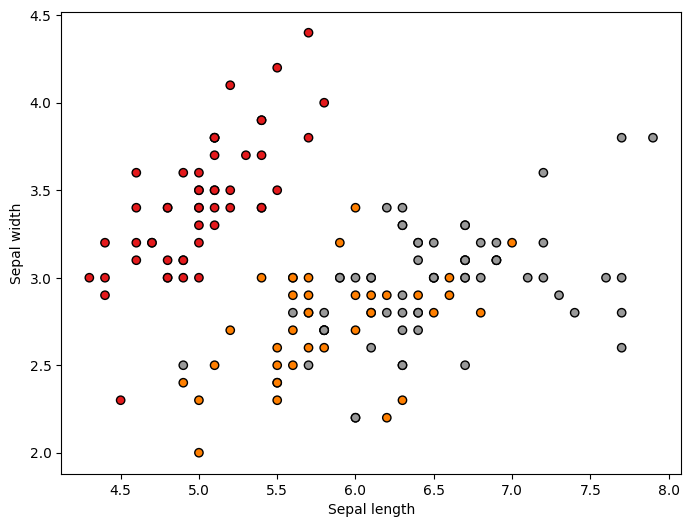

In [29]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage

**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [30]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [31]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [32]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [33]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris")

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

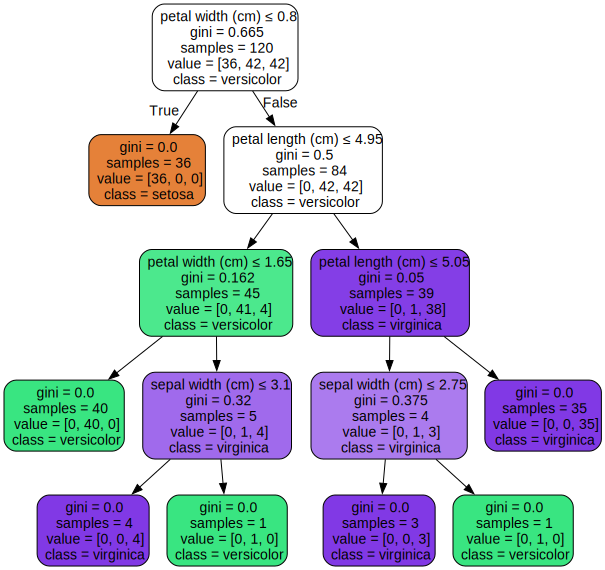

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=iris.feature_names,
                     class_names=iris.target_names,
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [ ]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [ ]:
sum(predictions == y_test) / len(y_test)

np.float64(0.9666666666666667)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [ ]:
y_test

array([1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 0, 2, 0,
       1, 2, 2, 2, 0, 0, 2, 0])


Here you can traverse the tree above by yourself and make sure that prediction works

In [ ]:
X_test[1]

array([6.9, 3.2, 5.7, 2.3])

In [ ]:
clf.predict([X_test[1]])

array([2])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Decision tree classifier (2 point)

###  Gini impurity


Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$


### Remarks


- We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.

In [ ]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray, number_of_classes: int):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

        self.number_of_classes = number_of_classes

    @property
    def probabilities(self):

        unique_labels, counts = np.unique(self.y, return_counts=True)

        counts_all_classes = np.zeros(self.number_of_classes)
        for label, count in zip(unique_labels, counts):
            counts_all_classes[int(label)] = count

        return (counts_all_classes + 1) / (len(self.y) + self.number_of_classes)

    @property
    def value(self):
        return np.argmax(self.probabilities)

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None

    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = np.unique(y).size

        self.tree = self._build_tree(X, y)


    def _get_best_split(self, X: npt.NDArray, y: npt.NDArray) -> dict:
        best_split: dict = {}
        min_gini = float('inf') # нам треба знайти найменший gini


        for feature_index in range(X.shape[1]):
            feature = X[:, feature_index]
            thresholds = np.unique(feature)

            for threshold in thresholds:
                # ділемо
                mask = feature <= threshold

                y_left = y[mask]
                y_right = y[~mask]

                if len(y_left) > 0 and len(y_right) > 0:
                    gini_left = self.get_gini(y_left)

                    gini_right = self.get_gini(y_right)

                    gini = (len(y_left) / len(y)) * gini_left + (len(y_right) / len(y)) * gini_right

                    if gini < min_gini:
                        min_gini = gini

                        X_left = X[mask, :]
                        X_right = X[~mask, :]

                        best_split = {'threshold':threshold,'feature_index': feature_index, 'X_left':X_left, 'X_right':X_right, 'y_left':y_left, 'y_right':y_right}

        return best_split

    @staticmethod
    def get_gini(y: npt.NDArray) -> float:
        # обрахувати кількість кожного типу
        y_counts = np.unique(y, return_counts=True)[1]

        # обраховуємо gini
        p = y_counts / len(y)
        gini = 1 - np.sum(p**2)
        return gini

    def _build_tree(self, X: npt.NDArray, y: npt.NDArray, current_depth:int = 0) -> Node:
        if len(np.unique(y)) == 1:
            return Node(X, y, self.number_of_classes)

        if current_depth >= self.max_depth:
            return Node(X, y, self.number_of_classes)

        split = self._get_best_split(X, y)

        if not split:
            return Node(X, y, self.number_of_classes)

        left_child = self._build_tree(split['X_left'], split['y_left'], current_depth + 1)
        right_child = self._build_tree(split['X_right'], split['y_right'], current_depth + 1)

        root = Node(X, y, self.number_of_classes)
        root.left = left_child
        root.right = right_child
        root.feature_index = split['feature_index']
        root.threshold = split['threshold']

        return root

    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it
        """
        predictions = []

        for x in X_test:
            node = self.tree
            while node.left and node.right:
                if x[node.feature_index] <= node.threshold:
                    node = node.left
                else:
                    node = node.right

            predictions.append(node.value)

        return predictions


In [ ]:

def evaluate(X_test: list[list], y_test: list, clf: DecisionTreeClassifier) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    predictions = np.array(clf.predict(X_test)).flatten()
    actual = np.array(y_test).flatten()
    return np.mean(predictions == actual)

### Your implementation

In [ ]:
accuracies = []
n_runs = 1000
max_depth = 5

for seed in range(n_runs):
    # Кожного разу інший поділ даних
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    clf = DecisionTreeClassifier(max_depth)
    clf.fit(X_train, y_train)

    accuracy = evaluate(X_test, y_test, clf)
    accuracies.append(accuracy)

accuracies = np.array(accuracies) * 100

print(f"--- Результати за {n_runs} запусків при максимальній глубині {max_depth} ---")
print(f"Мінімальна точність: {np.min(accuracies):.2f}%")
print(f"Максимальна точність: {np.max(accuracies):.2f}%")
print(f"Середня точність: {np.mean(accuracies):.2f}%")

--- Результати за 1000 запусків при максимальній глубині 5 ---
Мінімальна точність: 76.67%
Максимальна точність: 100.00%
Середня точність: 93.99%


#### Additional point (+0.5)

Use Laplace smoothing, explain what is the point of using it

Ми використовуємо laplace smoothing для вирішення проблеми нульової частоти. Адже навіть якщо виходить що шанс 0 відсотків, ми не можемо гаранувати це. І це особливо видно коли вибірка маленька. Таким чином ми кажемо, що завжди є шанс отрмати цей результат, хоч і малий. 